In [20]:
from bayesian_linear import BayesLinear
from negative_elbo import NegativeELBO
import torch
import numpy as np
import torch.nn.functional as F
from bayesian_linear import BayesLinear
from negative_elbo import NegativeELBO
import torch.utils.data as Data
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:
# Bayesian Neural Network
class BayesNN(torch.nn.Module):
    def __init__(self):
        super(BayesNN, self).__init__()
        self.bl1 = BayesLinear(1, 200)
        self.bl2 = BayesLinear(200, 100)
        self.bl3 = BayesLinear(100, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bl1(x))
        x = F.leaky_relu(self.bl2(x))
        x = self.bl3(x)
        return x


In [5]:
# Build data sets
def get_dset1():
    x1 = np.linspace(-3, -1, 20)
    y1 = np.ones_like(x1)
    x2 = np.linspace(-1, 1, 30)
    y2 = np.zeros_like(x2)
    x3 = np.linspace(1, 3, 20)
    y3 = np.ones_like(x3)

    X = torch.Tensor(np.concatenate([x1, x2, x3])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y2, y3]))
    return X, Y


def get_dset2():
    x1 = np.linspace(-3, -1, 20)
    y1 = 2* np.ones_like(x1)
    x2 = np.linspace(-1, 0, 20)
    y2 = -2*x2
    x3 = np.linspace(0, 1, 20)
    y3 = 2*x3
    x4 = np.linspace(1, 3, 20)
    y4 = 2*np.ones_like(x4)

    X = torch.Tensor(np.concatenate([x1, x2, x3, x4])).reshape(-1, 1)
    Y = torch.Tensor(np.concatenate([y1, y2, y3, y4]))
    return X, Y


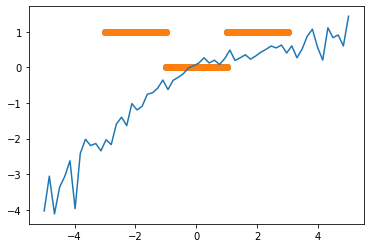

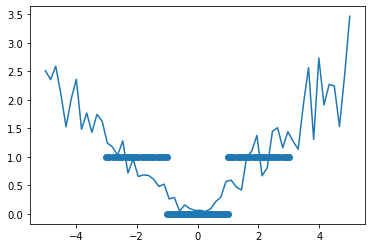

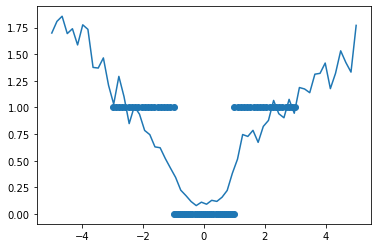

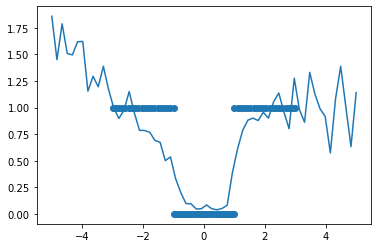

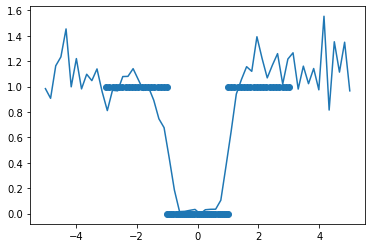

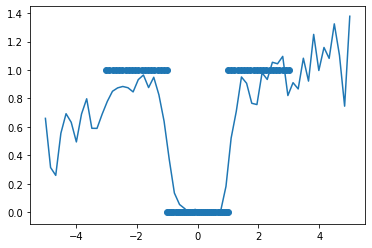

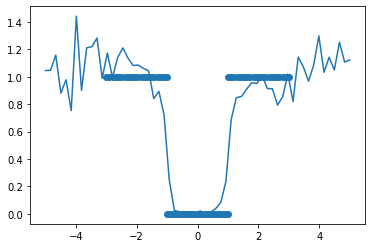

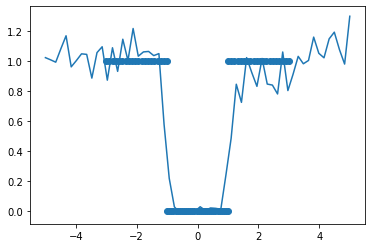

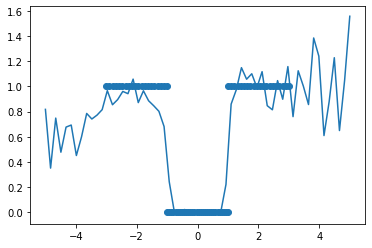

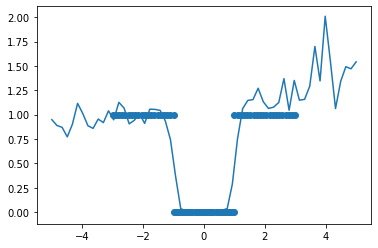

In [7]:
# Train the model
net = BayesNN()
# net = torch.nn.Sequential(
#     torch.nn.Linear(1, 200),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(200, 100),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(100, 1),
# )
neg_elbo = NegativeELBO(net)

# Create the dataset
X, Y = get_dset1()
plt.scatter(X, Y)

torch_dataset = Data.TensorDataset(X, Y)
BATCH_SIZE = 30
loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, num_workers=2)

num_epochs = 100

loss_fn = torch.nn.MSELoss()
loss_hist = []
optim = torch.optim.Adam(params=net.parameters(), lr=2e-2)


for epoch in range(num_epochs):
    for i, (batch_x, batch_y) in enumerate(loader):  # for each training step
        # loss = neg_elbo(X, Y, 0)
        Y_pred = net(batch_x).reshape(-1, )
        assert Y_pred.shape == batch_y.shape, print(Y_pred.shape, batch_y.shape)
        loss = loss_fn(batch_y, Y_pred)
        loss_hist.append(loss.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

    if epoch % 10 == 0:
        # Evaluate the model
        X_eval = torch.Tensor(np.linspace(-5, 5, 60)).reshape(-1, 1)
        Y_pred = net(X_eval)
        plt.scatter(X, Y)
        plt.plot(X_eval, Y_pred.detach().numpy())
        plt.show()

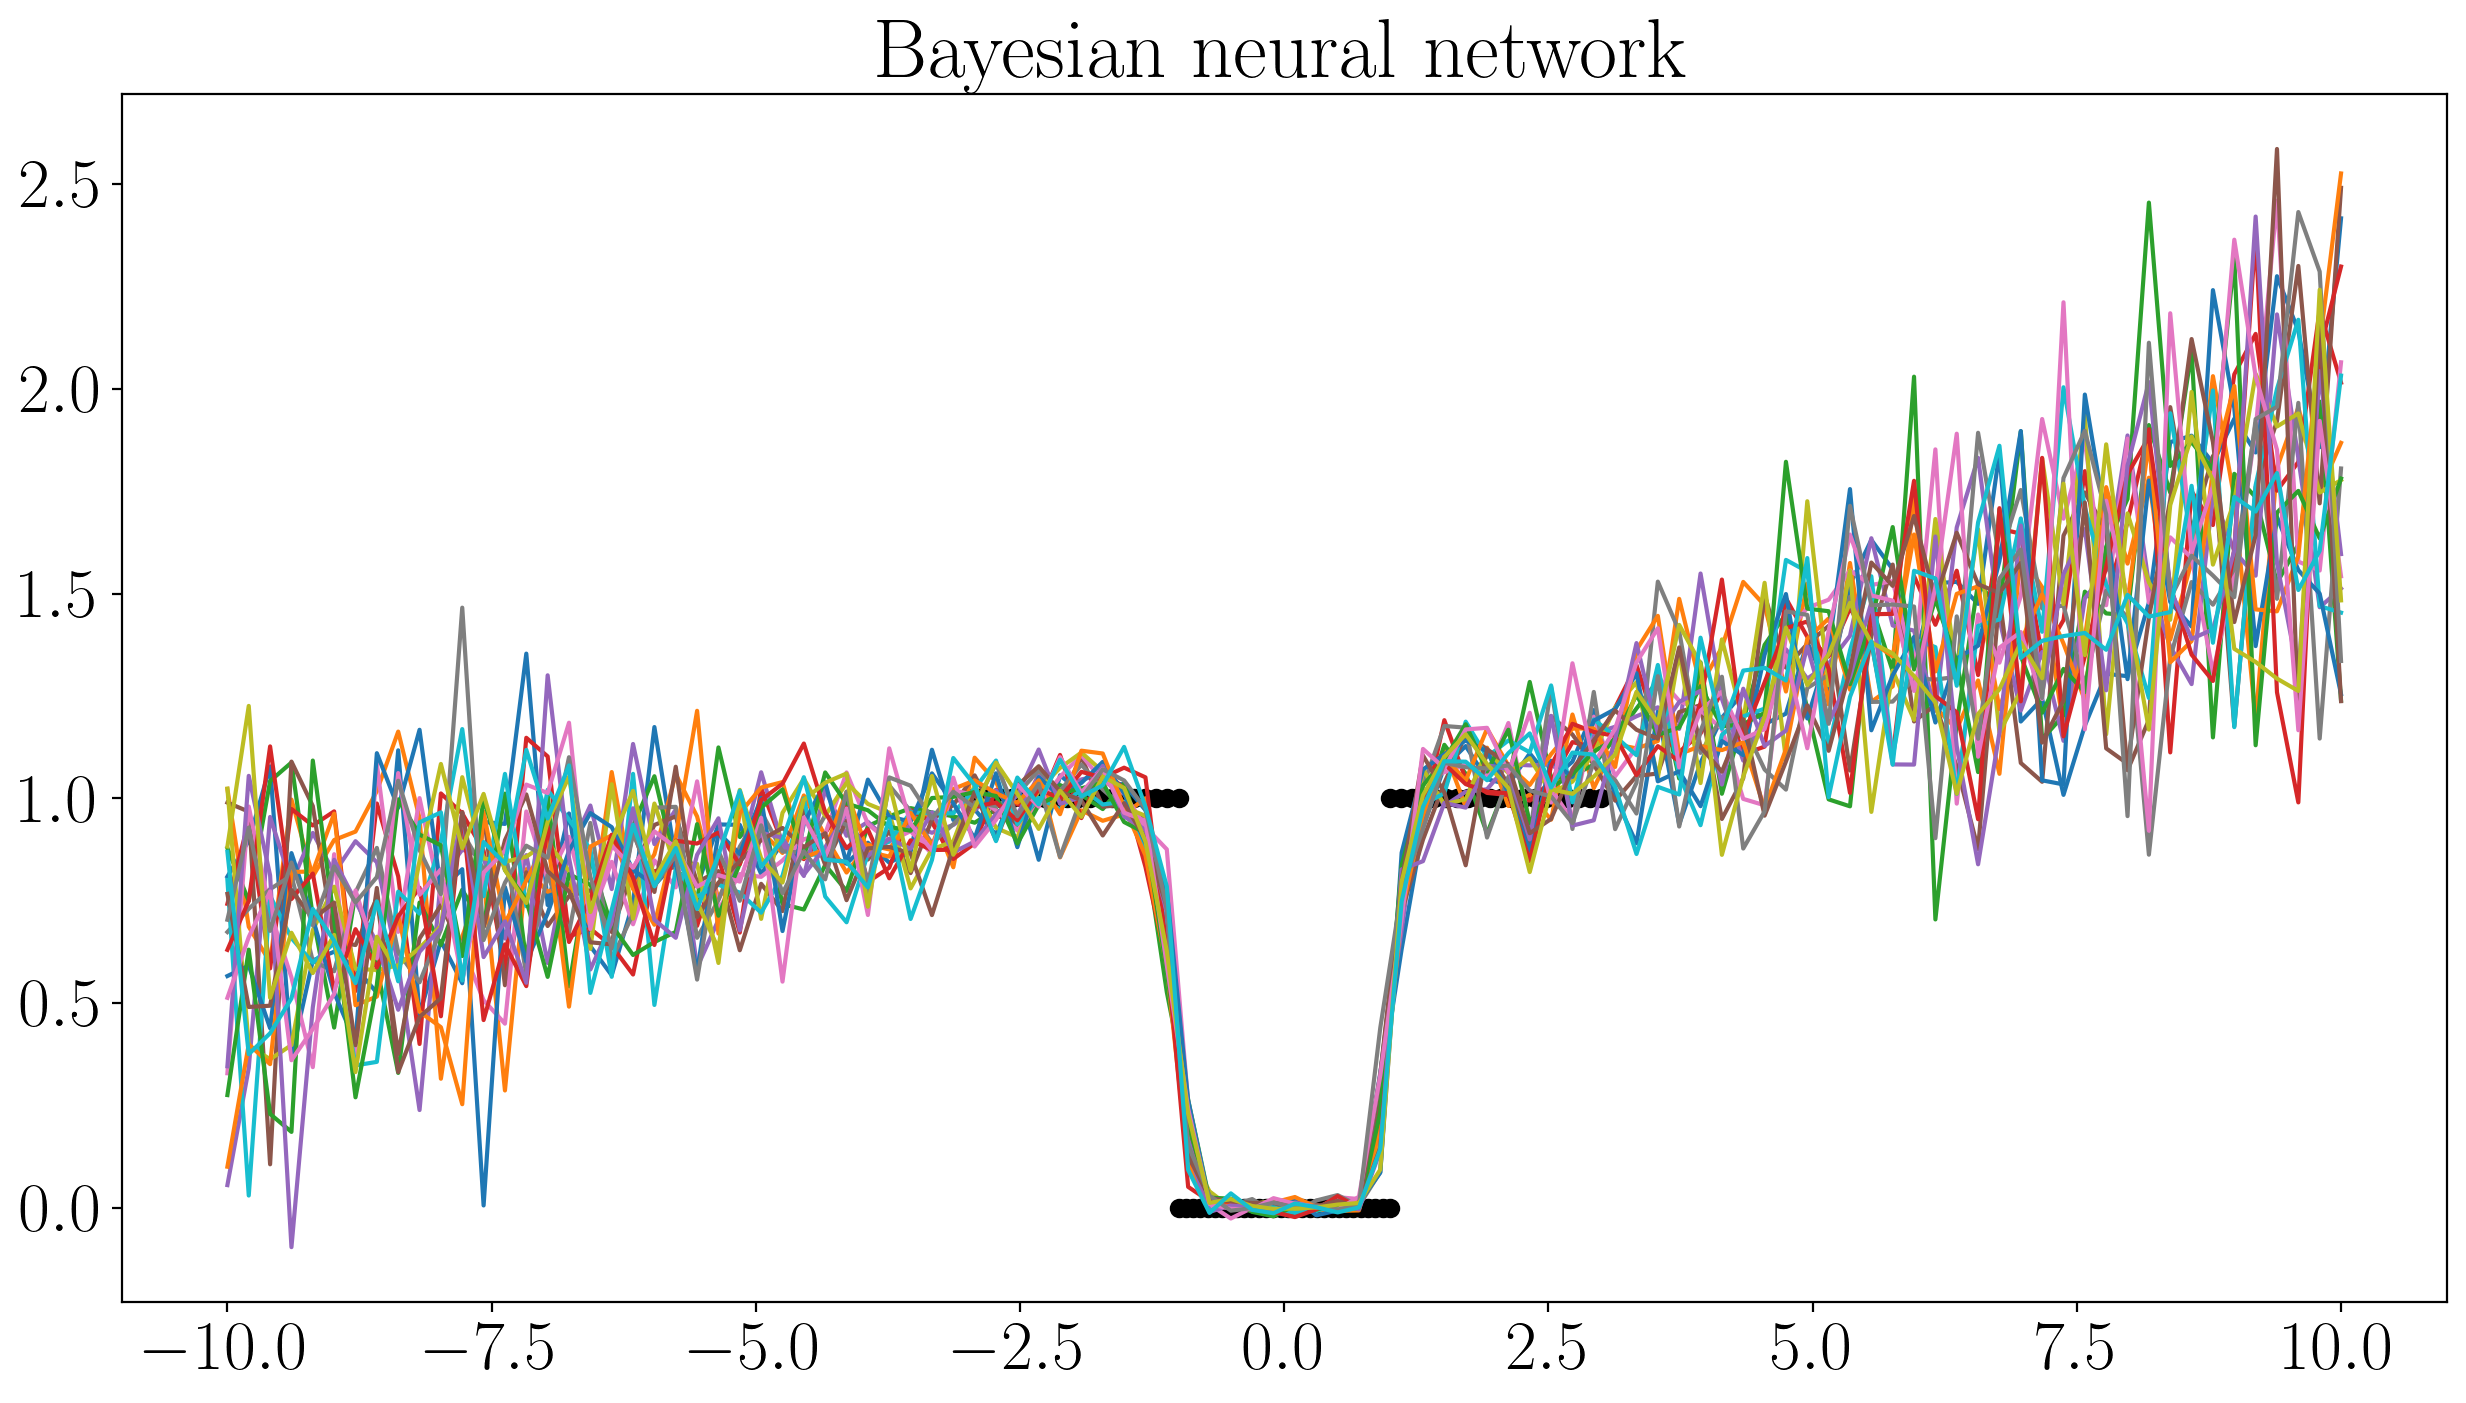

In [28]:
fig = plt.figure(dpi=200)
fig.set_figheight(8)
fig.set_figwidth(15)

for i in range(20):
    X_eval = torch.Tensor(np.linspace(-10, 10, 100)).reshape(-1, 1)
    Y_pred = net(X_eval)
    plt.plot(X_eval, Y_pred.detach().numpy())
plt.scatter(X, Y, c='k')
plt.xticks(size=25)
plt.yticks(size=25)
plt.plot()
plt.title("Bayesian neural network", size=30)
plt.savefig('figs/bnn.pdf', bbox_inches='tight',pad_inches = 0.1, dpi = 200)
